# Heuristic search

In [60]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def heuristic_search(max_iterations=100, 
                     space=(0,1,20), 
                     xi=None, 
                     yi=None, 
                     plot_reds=False, 
                     plot_only_last=False, 
                     seed=None
                     ):
        
    
    #start nested functions definitions
    def plot():
        fig = plt.figure(figsize=(13, 13))
        ax = plt.axes(projection='3d')
#         ax.scatter(a, b, c, c='black', marker='o', depthshade=False, s=60) 
        ax.plot(a, b, c, c="black", linewidth=4)
        ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1, cmap = 'jet', alpha=0.5)
        ax.scatter(X, Y, Z, marker='.', depthshade=False, s=10, alpha=0.5, c="gray")  
        if iteration > 0 and plot_reds:
            ax.scatter(reds[0], reds[1], reds[2], marker='o', depthshade=False, s=40, alpha=1.0, c="red")
        ax.scatter(ca, cb, cc, c='black', marker='o', depthshade=False, s=200, alpha=1.0)  


        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.zaxis.set_ticklabels([])
        ax.grid(False)
        ax.view_init(30, 20)

        return fig

    
    def get_z(u,w):
        return np.sin(np.pi*u)*np.sin(np.pi*w)
#         return abs(u-w)
#         return np.cos(u) * np.cos(w) * np.exp(-np.sqrt(u**2 + w**2)) / 4
#         return u * np.exp(-u**2 - w**2)
#         return u**2 - w**2
    
    def max_z():
        """Check four neighbors and return the one with max Z"""
        next_x, prev_x, next_y, prev_y = xi, xi, yi, yi
        
        if xi+1 < len(X[0]):
            next_x = xi+1
        if xi-1 >= 0:
            prev_x = xi-1
        if yi+1 < len(Y[0]):
            next_y = yi+1
        if yi-1 >= 0:
            prev_y = yi-1
        
        tz = -np.inf
        nxi = xi
        nyi = yi
        perm = itertools.product((next_x, prev_x), (next_y, prev_y))
        for i in perm:
            nz = get_z(X[0][i[0]],Y[i[1]][0])
            
            for k, n in enumerate([X[0][i[0]],Y[i[1]][0], nz]):
                    reds[k].append(n)
                        
            if nz >= tz:
                nxi = i[0]
                nyi = i[1]
                tz = nz
            

        
        return nxi, nyi
    

        
    # start actual function content
    iteration = 0
    rng = np.random.default_rng(seed)
    

    x_space = np.linspace(*space)
    y_space = np.linspace(*space)
    X, Y = np.meshgrid(x_space, y_space)
    Z = get_z(X, Y)

    if xi == None:
        xi = rng.integers(0,space[2]-1)
    if yi == None:
        yi = rng.integers(0,space[2]-1)

    a = []
    b = []
    c = []

    ca = X[0][xi]
    cb = Y[yi][0]
    cc = get_z(ca, cb)

    reds = [[],[],[]]

    while iteration <= max_iterations:
        iteration += 1
        a.append(ca)
        b.append(cb)
        c.append(cc)

        if plot_only_last:
            if iteration == max_iterations:
                 plot()
        else:
            yield plot()


        xi, yi = max_z()

        ca = X[0][xi]
        cb = Y[yi][0]
        cc = get_z(ca, cb)



## Schematic representation of a generic heuristic search

In [61]:
hs = heuristic_search(space=(-1,0.4,20), xi=17, yi=9)

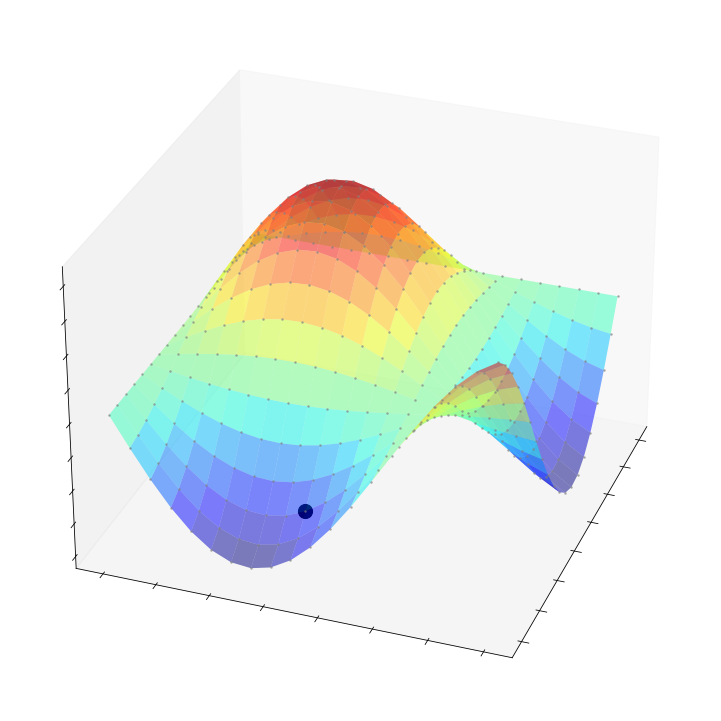

In [62]:
next(hs);

The explored space is significantly smaller in compairison with a exhaustive search

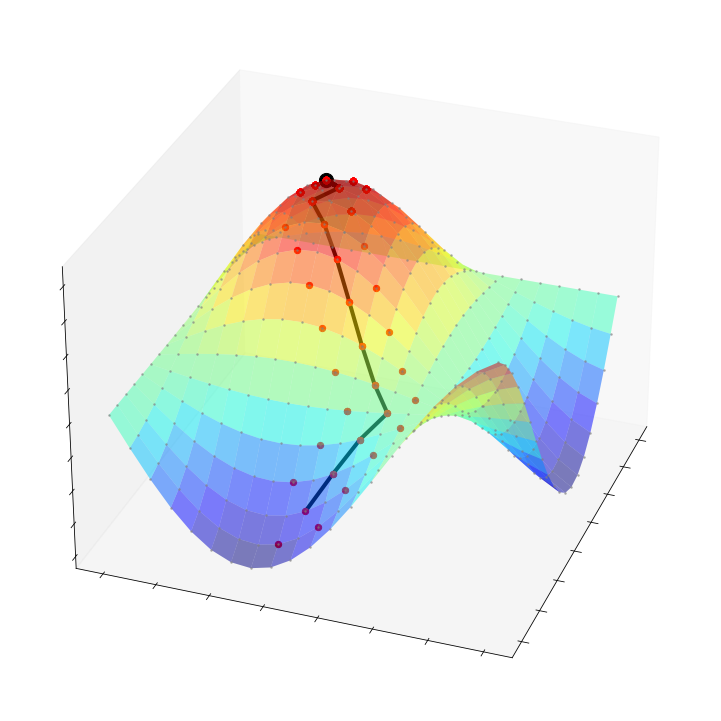

In [63]:
hs = heuristic_search(space=(-1,0.4,20), xi=17, yi=9, plot_only_last=True, plot_reds=True)
for i in hs: pass

Some other caveats

In [ ]:
# result sometimes depends of starting point 
hs = heuristic_search(space=(-1,0.4,20), xi=10, yi=18)

In [ ]:
next(hs);

In [ ]:
# big space and number of iterations
hs = heuristic_search(max_iterations=10, 
                      space=(-1,0.4,100), 
                      xi=90, yi=25, 
                      plot_only_last=True, 
                      plot_reds=False)
for i in hs: pass

# Nearest-neighbor interchanges (NNI)

In [257]:
from typing import Optional, TypeVar, Tuple
import numpy as np
import toytree


ToyTree = TypeVar("ToyTree")


def one_nni(tree: ToyTree,
            force: Tuple[int, int]=(-1, -1),
            seed: Optional[int]=None,
            highlight: bool=False,
            quiet: bool=True
       ) -> ToyTree:
    """Perfoms only ONE random swaping of two random subclades in a given tree
        
    Parameters
    ----------
    ...

    """
    
    # work in a copy of the tree
    tree = tree.copy()
    
    # for this version use only unrooted tree
    tree = tree.unroot()
    
    # create the random generator
    rng = np.random.default_rng(seed)
    
    if force[0] >= 0: 
        f_idx = force[0] #use user provided node
    else:
        # randomly select first subtree (any non-root Node)
        f_idx = rng.choice(tree.nnodes - 1)  
    
    
    subtree_a = tree[f_idx]  

    
    # Check available nodes to select second subtree
    # It should follow the following statements
    available_nodes = (
        set(range(tree.nnodes - 1)) # set with all possible nodes but the root
        - set((i._idx for i in subtree_a._iter_descendants())) # remove descendants of subtree
        - set((i._idx for i in subtree_a._iter_ancestors())) # remove all ancestors of subtree
        - set((i._idx for i in subtree_a._iter_sisters())) # remove sisters of subtree (to avoid uninformative interchange)
        - set((subtree_a._up._idx, )) # remove  parental of subtree (to avoid pick a subtree with subtree_a in there)
        - set((subtree_a._idx, )) # remove subtree node itself
    )
    
    
    
    # If the random subtree is very basal, no other options are available to swap subtrees
    if not available_nodes:
        if not quiet: print(f"No possible interchange if {subtree_a!r} is selected")
        return None
    else:
        if not quiet: print(f"Possible interchanges for {subtree_a!r} are: {available_nodes}")
    
    
    
    if force[1] >= 0: 
        s_idx = force[1] #use user provided node
    else:
    # randomly select second subtree to interchange
        s_idx = rng.choice(list(available_nodes))
    

    subtree_b = tree[s_idx]


    if not quiet: print(f"Interchanging {subtree_a!r} with {subtree_b!r}")


    # set in memory the idx of both parents (parent of a = 1 and parent of b = 2)
    parent_1 = subtree_a._up.idx
    parent_2 = subtree_b._up.idx
    
    # remove swaping subtrees from the tree
    tree[parent_1]._remove_child(tree[subtree_a.idx])
    tree[parent_2]._remove_child(tree[subtree_b.idx])
    
    # add the subtrees in the new parents (a to 2 and b to 1)
    tree[parent_1]._add_child(tree[subtree_b.idx])
    tree[parent_2]._add_child(tree[subtree_a.idx])

    # call toytree update routine
    tree._update()


    # show subtrees swapped 
    if highlight:
        tree.style.edge_colors = ['black'] * tree.nnodes
        tree.style.node_colors = ['white'] * tree.nnodes
        tree.style.node_style.stroke_width = 1.5
        tree.style.node_sizes = 15
        tree.style.node_labels = "idx"
        tree.style.node_labels_style.font_size = 8
#         tree.style.node_labels_style._toyplot_anchor_shift = -12
#         tree.style.node_labels_style.baseline_shift = 9
        tree.style.tip_labels_style._toyplot_anchor_shift = -12
        tree.style.tip_labels_style.baseline_shift = 9



        for it, subtree in enumerate([subtree_a, subtree_b]):
            for node in subtree._iter_descendants():
                if node:
                    tree.style.edge_colors[node.idx] = toytree.color.COLORS2[it]
                    tree.style.node_colors[node.idx] = toytree.color.COLORS2[it]

    # remove lenghts
    tree.style.use_edge_lengths = False
        
    
    return tree

Let see this this algorithm in action swaping a random subtree.

In [258]:
tree = toytree.rtree.unittree(4, seed=123)
tree = tree.unroot()

tree.draw(node_labels="idx", node_sizes=15, layout="unrooted", use_edge_lengths=False, tip_labels_style={"_toyplot_anchor_shift": 12, "baseline_shift": 9});

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="260.0px" viewBox="0 0 350.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t83b4b96d014d44d4b737091cfd15db08"> 4 5 r0 r1 r2 r3

In [259]:
tresult = one_nni(tree, highlight=True, quiet=False)
if tresult: 
    tresult.draw(layout="unrooted")

Possible interchanges for Node(0, r0) are: {2, 3}
Interchanging Node(0, r0) with Node(3, r3)


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="260.0px" viewBox="0 0 350.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t322d8d8fdd44430daf609878145c439b"> 4 5 r1 r2 r0 r3

We can develop a heuristic search only using the first neighbor found, but this will be suboptimal in and already suboptimal solution (lazy mode). Certainly, it will faster, but let see a code to generate all possible nearest neighbors of a tree when we swap a given node.

In [303]:
def get_all_neighbors_nni(tree,
                         node=None,
                         highlight=True, 
                         seed=None,
                         quiet=True,
                         ):
    """Given a tree performs multiple NNI to get all the neighbors
    given a node. If not is not provided, it is selected randomly.
    """
    
    tree = tree.copy()
    tree = tree.unroot()
    
    rng = np.random.default_rng(seed)
    
    # randomly select first subtree (any non-root Node)
    if node == None:
        f_idx = rng.choice(tree.nnodes - 1)  
    else:
        f_idx = node #use node specified by user
    
    
    subtree_a = tree[f_idx]
    
    if not quiet: print(f"There are {2 * (tree.ntips - 3)} expected nearest neighbors for the given tree (unrooted) swapping {subtree_a!r}")
       
      
    # Check available nodes to select second subtree
    # It should follow the following statements
    available_nodes = (
        set(range(tree.nnodes - 1)) # set with all possible nodes but the root
        - set((i._idx for i in subtree_a._iter_descendants())) # remove descendants of subtree
        - set((i._idx for i in subtree_a._iter_ancestors())) # remove all ancestors of subtree
        - set((i._idx for i in subtree_a._iter_sisters())) # remove sisters of subtree (to avoid uninformative interchange)
        - set((subtree_a._up._idx, )) # remove  parental of subtree (to avoid pick a subtree with subtree_a in there)
        - set((subtree_a._idx, )) # remove subtree node itself
    )
    

    for n_neighbor, available_node in enumerate(available_nodes):
        if not quiet: print(f"Neighbor {n_neighbor + 1} of {2 * (tree.ntips - 3)}")
    
        yield one_nni(tree, force=(f_idx, available_node), highlight=highlight, quiet=True, seed=seed)


So, now we can get all nearest neighbors of a given tree

In [337]:
tree = toytree.rtree.unittree(5, seed=42)
tree = tree.unroot()

tree.draw(node_labels="idx", node_sizes=15, layout="unrooted", use_edge_lengths=False, tip_labels_style={"_toyplot_anchor_shift": 12, "baseline_shift": 9});

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="260.0px" viewBox="0 0 350.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tb9fc62aa3dce4144b6f0d1036345503d"> 5 6 7 r0 r1 r2 r3 r4

In [361]:
neighbors_generator = get_all_neighbors_nni(tree, node=0, quiet=False)

In [363]:
next(neighbors_generator).draw(layout="unrooted");

Neighbor 2 of 4


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="260.0px" viewBox="0 0 350.0 260.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t01aad411200643f489f0f71ba38451dd"> 5 6 7 r1 r2 r4 r0 r3

In [364]:
multi_tree = toytree.mtree([nt for nt in get_all_neighbors_nni(tree, node=0)])

In [365]:
multi_tree.draw(layout="unrooted");

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="750.0px" height="250.0px" viewBox="0 0 750.0 250.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t3c34e174a922432783f2b40fb73c2167"> 5 6 7 r1 r3 r4 r0 r2 5 6 7 r1 r2 r4 r0 r3 5 6 7 r1 r2 r3 r0 r4 5 6 7 r1 r2 r0 r3 r4

# Subtree pruning and regrafting (SPR)

In [82]:
from typing import Optional, TypeVar
import numpy as np
import toytree


ToyTree = TypeVar("ToyTree")

def spr(
    tree: ToyTree,
    seed: Optional[int]=None,
    highlight: bool=False,
    quiet: bool=True,
    ) -> ToyTree:
    """Return a rooted ToyTree one SPR move from the current tree.
    The returned tree will have a different topology from the starting
    tree, at an SPR distance of 1. It randomly samples a subtree to
    extract from the tree, and then reinserts the subtree at an edge
    that is not (1) one of its descendants; (2) its sister; (3) its
    parent; or (4) itself.
    Parameters
    ----------
    ...
    Examples
    --------
    >>> ...
    """
    tree = tree.copy()
    rng = np.random.default_rng(seed)

    # randomly select a subtree (any non-root Node)
    sidx = rng.choice(tree.nnodes - 1)
    subtree = tree[sidx]

    # get list of Nodes (edges) where subtree can be inserted. This
    # cannot be root, or a desc on the subtree Node, or the subtree itself.
    edges = (
        set(range(tree.nnodes)) 
        - set((i._idx for i in subtree._iter_descendants())) 
        - set((i._idx for i in subtree._iter_sisters())) 
        - set((subtree._up._idx, )) 
        - set((subtree._idx, ))
    )

    # sample an edge by its descendant Node
    new_sister = tree[rng.choice(list(edges))]
    if not quiet: print(f"Prunning {subtree!r} to regrafting in {new_sister!r}")

    # connect subtree to new sister by inserting a new Node
    new_node = toytree.Node("new")
    new_node_parent = new_sister._up
    new_node._up = new_node_parent
    new_node._children = (subtree, new_sister)
    
    old_node = subtree._up
    old_node_parent = old_node._up
    
    # remove 12 and connect 11 to 14
    old_node._remove_child(subtree)
    if old_node_parent:
        old_node_parent._remove_child(old_node)
        for child in old_node._children:
            old_node_parent._add_child(child)
            child._dist += old_node._dist 
    del old_node

    # connect subtree to tree   
    subtree._up = new_node
    new_sister._up = new_node
    if new_node_parent:
        new_node_parent._remove_child(new_sister)
        new_node_parent._add_child(new_node)

    # if old root is now a singleton b/c new_sister is one of its children
    if len(tree.treenode.children) == 1:
        tree.treenode = tree.treenode.children[0]
        oldroot = tree.treenode._up
        tree.treenode._up = None
        del oldroot

    # if new_sister is now the root.
    elif new_sister == tree.treenode:
        tree.treenode = new_node
        
        
    tree._update()

    # optional: color edges of the subtree that was moved.
    if highlight:
        tree.style.edge_colors = ['black'] * tree.nnodes
        tree.style.node_colors = ['white'] * tree.nnodes
        tree.style.node_style.stroke_width = 1.5
        tree.style.node_sizes = 8
        tree.style.node_labels = "idx"
        tree.style.node_labels_style.font_size = 8
        tree.style.node_labels_style._toyplot_anchor_shift = -12
        tree.style.node_labels_style.baseline_shift = 9


        # tree.get_mrca_node(*tips)
        for node in subtree._iter_descendants():
            tree.style.edge_colors[node.idx] = toytree.color.COLORS2[3]
            tree.style.node_colors[node.idx] = toytree.color.COLORS2[3]
        tree.style.node_colors[new_node.idx] = toytree.color.COLORS2[3]
        
    # remove lenghts
    tree.style.use_edge_lengths = False
    
    return tree

In [83]:
tree = toytree.rtree.unittree(5, seed=42)
tree.draw(node_labels="idx", node_sizes=15);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="260.0px" height="275.0px" viewBox="0 0 260.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf35962b1b1864317ae4d25fa8108de98"> 5 6 7 8 r0 r1 r2 r3 r4

In [84]:
tm = spr(tree, highlight=True, seed=None).draw()

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="260.0px" height="275.0px" viewBox="0 0 260.0 275.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t7e3a62e4a8914c07b714f3272051d29b"> 5 6 7 8 r1 r2 r3 r4 r0